<html> <h1 style="font-style:bold; color:blue;"> Neural Computing and Deep Learning </h1> </html>

<html> <h1 style="font-style:italic; color:blue;"> Week-12 </h1> </html>

<html> <h2 style="font-style:italic; color:blue;"> Attention Networks </21> </html>

The tutorial will cover the following:

* Preparing a simple dataset for time series forecasting
* How to use a network built via SimpleRNN for time series forecasting
* Adding a custom attention layer to the SimpleRNN network

_________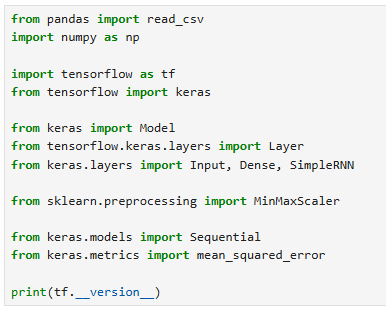

In [4]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from keras import  Model, Sequential
from keras.layers import Layer, Input, Dense, SimpleRNN

from sklearn.preprocessing import MinMaxScaler
from keras.metrics import mean_squared_error

print(tf.__version__)

2.10.1


### The Dataset

We will create a fibonacci sequence dataset for our purpose. In Fibonacci sequence, one number is constructed from the previous two numbers. The first 10 numbers of the sequence are shown below:

0, 1, 1, 2, 3, 5, 8, 13, 21, 34, …


When given the previous ‘t’ numbers, can you get a machine to accurately reconstruct the next number? This would mean discarding all the previous inputs except the last two and performing the correct operation on the last two numbers.

For this tutorial, you’ll construct the training examples from t time steps and use the value at t+1 as the target. For example, if t=3, then the training examples and the corresponding target values would look as follows:


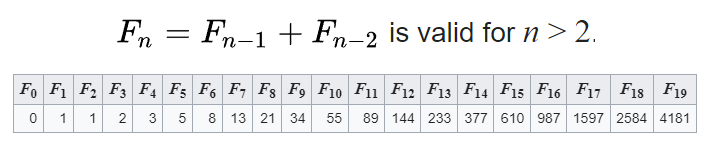

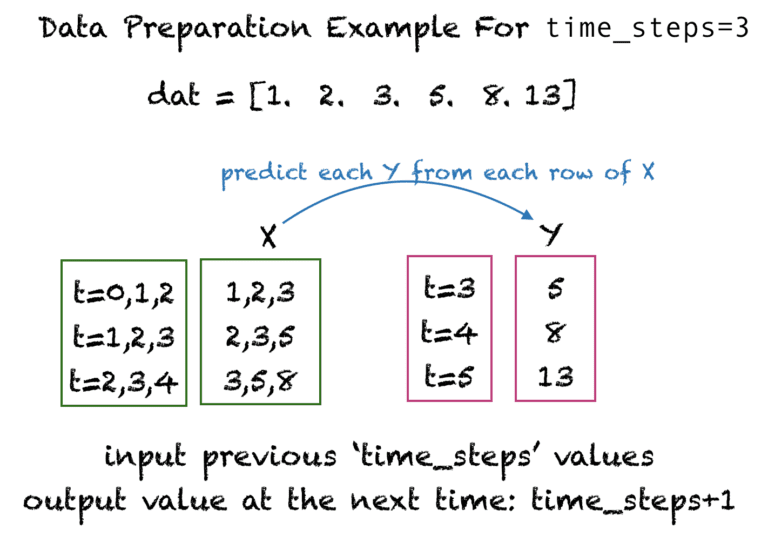

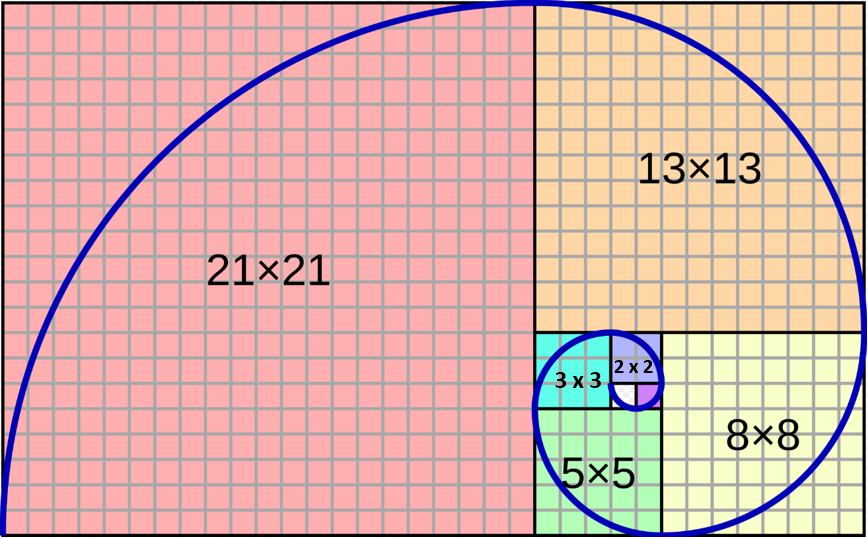

The Fibonacci spiral: an approximation of the **golden spiral** created by drawing circular arcs connecting the opposite corners of squares in the Fibonacci tiling

### Data preprocessing

_____________________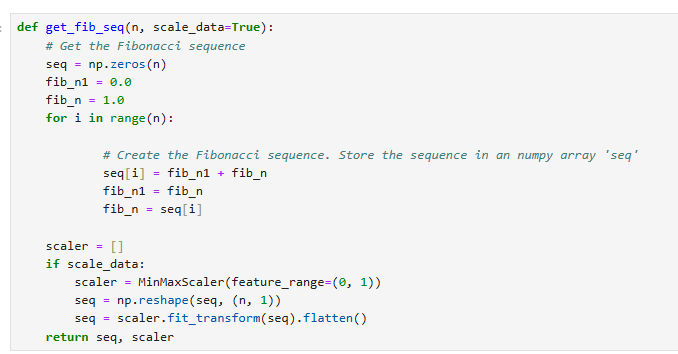

In [5]:
def get_fib_seq(n, scale_data=True):
    seq=np.zeros(n)
    fib_n1 = 0.0
    fib_n = 1.0
    for i in range(n):
        seq[i] = fib_n1 + fib_n
        fib_n1 = fib_n
        fib_n = seq[i]
    
    scaler = []

    if scale_data:
        scaler = MinMaxScaler(feature_range=(0,1))
        seq = np.reshape(seq, (n,1))
        seq = scaler.fit_transform(seq).flatten()
    
    return seq, scaler

#### Hint:

You can copy blocks of code in the cells above and cells from previous weeks of practice sessions.

Some are easy enough to copy, some need to be slightly modified. This can speed up your code creation.

In [6]:
# Check if the function works correctly:
# Copy the previous cell, change the function name and add fib_n 

________________________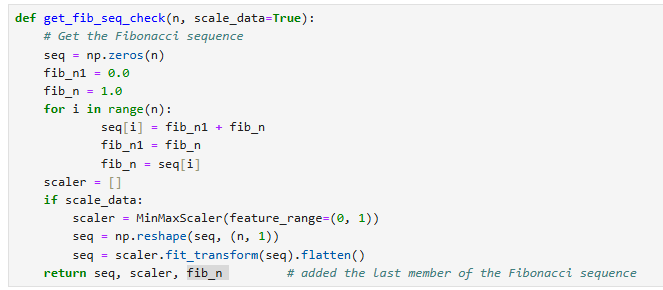

In [7]:
def get_fib_seq_check(n, scale_data=True):
    seq=np.zeros(n)
    fib_n1 = 0.0
    fib_n = 1.0
    for i in range(n):
        seq[i] = fib_n1 + fib_n
        fib_n1 = fib_n
        fib_n = seq[i]
    
    scaler = []

    if scale_data:
        scaler = MinMaxScaler(feature_range=(0,1))
        seq = np.reshape(seq, (n,1))
        seq = scaler.fit_transform(seq).flatten()
    
    return seq, scaler, fib_n

_________________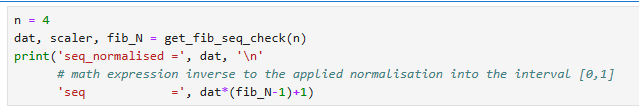

In [8]:
n = 4
dat, scaler, fib_N = get_fib_seq_check(n)
print(f" seq_normalised = \t {dat} \n seq \t {dat*(fib_N-1)+1}")

 seq_normalised = 	 [0.   0.25 0.5  1.  ] 
 seq 	 [1. 2. 3. 5.]


In [9]:
# Your code for the same checking with n=6 

#
#
#
n = 6
dat, scaler, fib_N = get_fib_seq_check(n)
print(f" seq_normalised = \t {dat} \n seq \t {dat*(fib_N-1)+1}")

 seq_normalised = 	 [0.         0.08333333 0.16666667 0.33333333 0.58333333 1.        ] 
 seq 	 [ 1.  2.  3.  5.  8. 13.]


In [10]:
# Your code for the same checking with n=8 

#
#
#
n = 8
dat, scaler, fib_N = get_fib_seq_check(n)
print(f" seq_normalised = \t {dat} \n seq \t {dat*(fib_N-1)+1}")

 seq_normalised = 	 [0.         0.03030303 0.06060606 0.12121212 0.21212121 0.36363636
 0.60606061 1.        ] 
 seq 	 [ 1.  2.  3.  5.  8. 13. 21. 34.]


In [11]:
# Your code for the same checking with n=10 

#
#
#
n = 10
dat, scaler, fib_N = get_fib_seq_check(n)
print(f" seq_normalised = \t {dat} \n seq \t {dat*(fib_N-1)+1}")

 seq_normalised = 	 [0.         0.01136364 0.02272727 0.04545455 0.07954545 0.13636364
 0.22727273 0.375      0.61363636 1.        ] 
 seq 	 [ 1.  2.  3.  5.  8. 13. 21. 34. 55. 89.]


___________________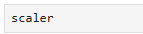

In [12]:
scaler

MinMaxScaler()

### The following function transforms the fibonacci sequence into training and test dataset.

X and Y looks like the following. From X and Y, we create training and test dataset.


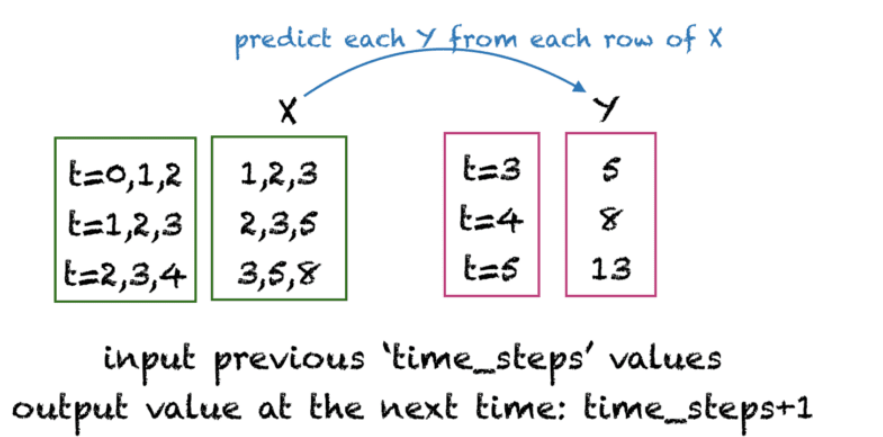

____________________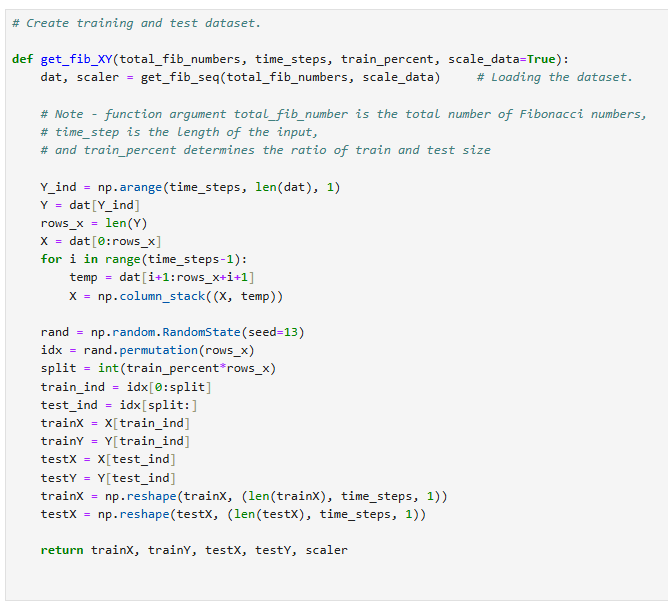

In [13]:
def get_fib_XY(total_fib_numbers, time_steps, train_percent, scale_data=True):
    dat, scaler = get_fib_seq(total_fib_numbers, scale_data)
    Y_ind = np.arange(time_steps, len(dat), 1)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[0:rows_x]
    for i in range(time_steps - 1):
        temp = dat[i+1:rows_x+i+1]
        X = np.column_stack((X,temp))
    rand = np.random.RandomState(seed=13)
    idx = rand.permutation(rows_x)
    split = int(train_percent*rows_x)
    train_ind = idx[0:split]
    test_ind = idx[split:]
    trainX = X[train_ind]
    trainY = Y[train_ind]
    testX = X[test_ind]
    testY = Y[test_ind]
    trainX = np.reshape(trainX,(len(trainX), time_steps, 1))
    testX = np.reshape(testX,(len(testX), time_steps, 1))
    return trainX, trainY, testX, testY, scaler

_________________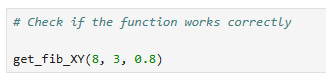

In [14]:
get_fib_XY(8,3, 0.8)

(array([[[0.03030303],
         [0.06060606],
         [0.12121212]],
 
        [[0.12121212],
         [0.21212121],
         [0.36363636]],
 
        [[0.21212121],
         [0.36363636],
         [0.60606061]],
 
        [[0.        ],
         [0.03030303],
         [0.06060606]]]),
 array([0.21212121, 0.60606061, 1.        , 0.12121212]),
 array([[[0.06060606],
         [0.12121212],
         [0.21212121]]]),
 array([0.36363636]),
 MinMaxScaler())

In [15]:
#np.column_stack?

In [16]:
#np.random.RandomState.permutation?

### In the following code, we test the performance with the help of a simple RNN.


#### Set up parameters

__________________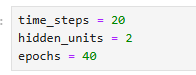

In [17]:
time_steps = 20
hidden_units = 4
epochs = 52

#### Create a traditional RNN network

______________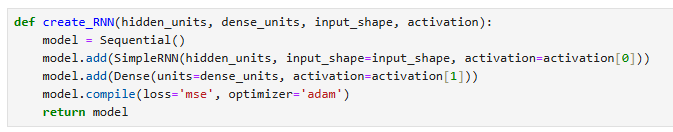

In [18]:
def CreateRNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mse', optimizer='adam')
    return model

___________________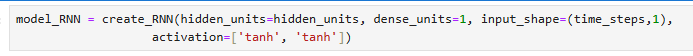

In [19]:
model_RNN = CreateRNN(hidden_units=hidden_units, dense_units=1, input_shape=(time_steps,1), activation=['tanh', 'tanh'])

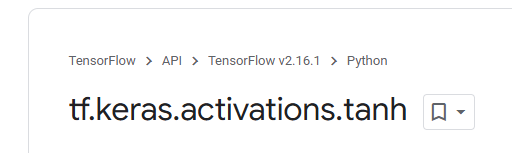

##### tf.keras.activations.tanh

https://www.tensorflow.org/api_docs/python/tf/keras/activations/tanh

In [20]:
# Your code to print the model summary

#
#
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 4)                 24        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


________________________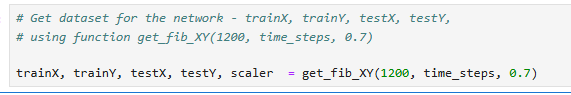

In [21]:
trainX, trainY, testX, testY, scaler = get_fib_XY(1200, time_steps, 0.7)

#### Train the network

_____________________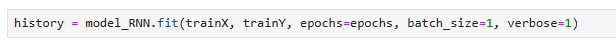

In [22]:
history = model_RNN.fit(trainX,trainY, epochs=epochs, batch_size=1, verbose=1)

Epoch 1/52
826/826 [==============================] - 23s 23ms/step - loss: 4.5769e-04
Epoch 2/52
826/826 [==============================] - 18s 22ms/step - loss: 3.6495e-04
Epoch 3/52
826/826 [==============================] - 18s 22ms/step - loss: 2.7614e-04
Epoch 4/52
826/826 [==============================] - 18s 22ms/step - loss: 2.1823e-04
Epoch 5/52
826/826 [==============================] - 18s 22ms/step - loss: 1.5507e-04
Epoch 6/52
826/826 [==============================] - 18s 22ms/step - loss: 1.1099e-04
Epoch 7/52
826/826 [==============================] - 18s 21ms/step - loss: 8.3737e-05
Epoch 8/52
826/826 [==============================] - 17s 20ms/step - loss: 6.7815e-05
Epoch 9/52
826/826 [==============================] - 18s 22ms/step - loss: 6.1281e-05
Epoch 10/52
826/826 [==============================] - 18s 22ms/step - loss: 6.0706e-05
Epoch 11/52
826/826 [==============================] - 19s 23ms/step - loss: 6.0384e-05
Epoch 12/52
826/826 [====================

____________________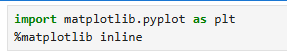

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

#### Hint:

You can copy blocks of code in the cells above and cells from previous weeks of practice sessions.

Some are easy enough to copy, some need to be slightly modified. This can speed up your code creation.

___________________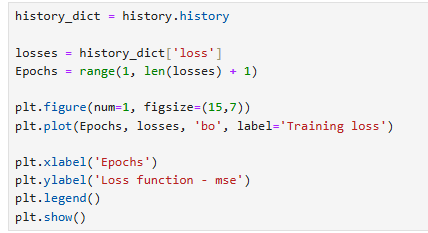

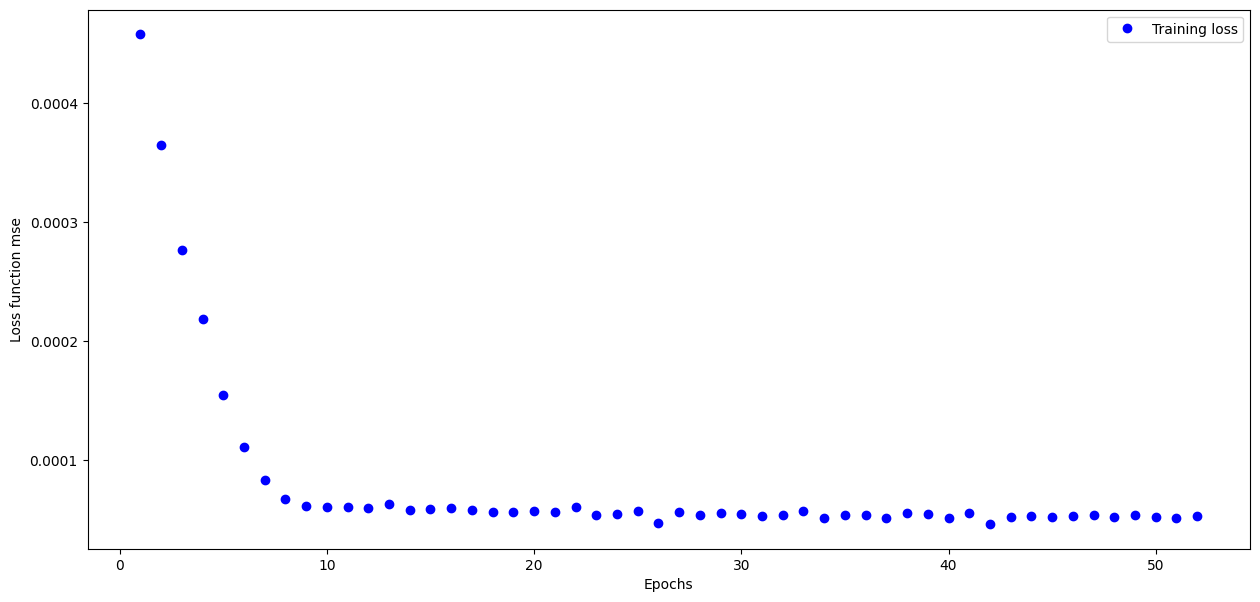

In [24]:
history_dict = history.history
losses = history_dict['loss']
Epochs = range(1, len(losses) + 1)
plt.figure(num=1, figsize=(15,7))
plt.plot(Epochs, losses, 'bo', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function mse')
plt.legend()
plt.show()

#### Evalute model

____________________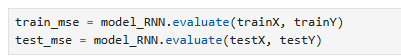

In [25]:
train_mse = model_RNN.evaluate(trainX, trainY)
test_mse = model_RNN.evaluate(testX, testY)

12/12 [==============================] - 0s 11ms/step - loss: 2.5703e-05


#### Print train and test error metrics

__________________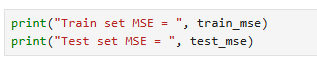

In [26]:
print("Train set MSE = ", train_mse)
print("Test set MSE = ", test_mse)

Train set MSE =  4.242875729687512e-05
Test set MSE =  2.570277138147503e-05


In [27]:
print("Train set MSE = ", train_mse)
print("Test set MSE = ", test_mse)

Train set MSE =  4.242875729687512e-05
Test set MSE =  2.570277138147503e-05


### The following code creates an attention layer. You need to understand each line to know how an attention layer can be created. 


_____________________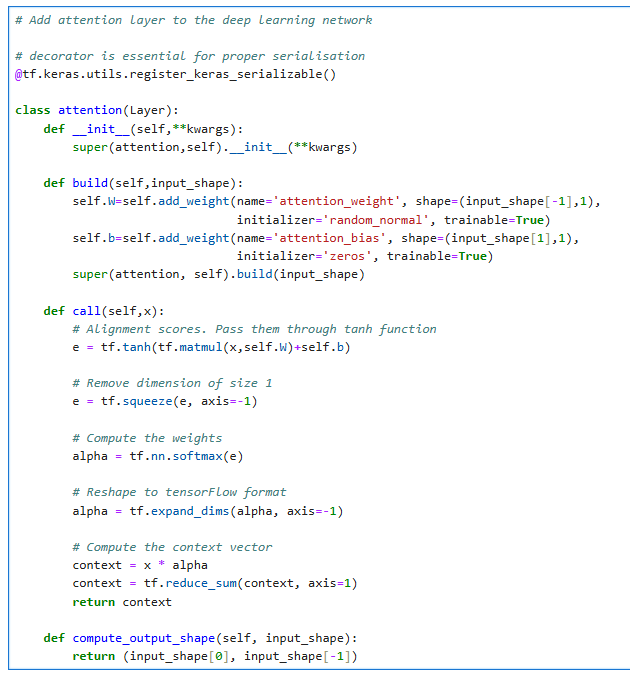

In [28]:
@tf.keras.utils.register_keras_serializable()
class attention(Layer):
    def __init__(self, **kwargs):
        super(attention, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W= self.add_weight(name='attention weight', shape=(input_shape[-1],1), initializer='random_normal',trainable=True)
        self.b = self.add_weight(name='attention bias', shape=(input_shape[1],1), initializer='zeros',trainable=True)
        super(attention, self).build(input_shape)
    
    def call(self, x):
        e = tf.tanh(tf.matmul(x, self.W)+self.b)
        e = tf.squeeze(e, axis=-1)
        alpha = tf.nn.softmax(e)
        alpha = tf.expand_dims(alpha, axis=-1)
        context = x*alpha
        context = tf.reduce_sum(context, axis=1)
        return context
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


### The following code develops an RNN with an attention layer to predict the Fibonacci sequence.



________________________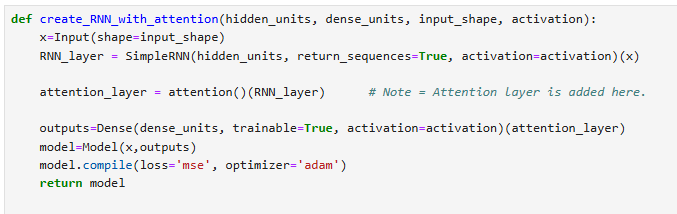

In [29]:
def create_RNN_with_attention(hidden_units, dense_units, input_shape, activation):
    x=Input(shape=input_shape)
    RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
    attention_layer= attention()(RNN_layer)
    outputs = Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    model=Model(x,outputs)
    model.compile(loss='mse', optimizer='adam')
    return model

________________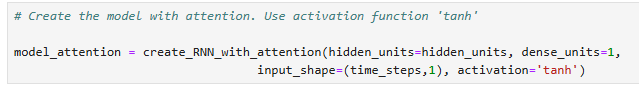

In [30]:
model_attention = create_RNN_with_attention(hidden_units=hidden_units, dense_units=1, input_shape=(time_steps,1), activation='tanh')

In [31]:
# Your code to print the model summary

#
#
model_attention.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 4)             24        
                                                                 
 attention (attention)       (None, 4)                 24        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Your code to fit the model
# save the results of the training to 'history_2' variable list
# use batch_size=1

#
#
history2 = model_attention.fit(trainX,trainY, epochs=epochs, batch_size=1, verbose=1)

Epoch 1/52
826/826 [==============================] - 22s 26ms/step - loss: 0.0013
Epoch 2/52
826/826 [==============================] - 21s 26ms/step - loss: 0.0013
Epoch 3/52
826/826 [==============================] - 22s 26ms/step - loss: 0.0013
Epoch 4/52
826/826 [==============================] - 22s 26ms/step - loss: 0.0013
Epoch 5/52
826/826 [==============================] - 22s 26ms/step - loss: 0.0012
Epoch 6/52
826/826 [==============================] - 22s 26ms/step - loss: 0.0012
Epoch 7/52
826/826 [==============================] - 22s 26ms/step - loss: 0.0011
Epoch 8/52
826/826 [==============================] - 21s 26ms/step - loss: 0.0011
Epoch 9/52
826/826 [==============================] - 22s 26ms/step - loss: 0.0010
Epoch 10/52
826/826 [==============================] - 21s 25ms/step - loss: 9.6452e-04
Epoch 11/52
826/826 [==============================] - 21s 25ms/step - loss: 8.8112e-04
Epoch 12/52
826/826 [==============================] - 22s 26ms/step - loss: 

#### Hint:

You can copy blocks of code in the cells above and cells from previous weeks of practice sessions.

Some are easy enough to copy, some need to be slightly modified. This can speed up your code creation.


_______________________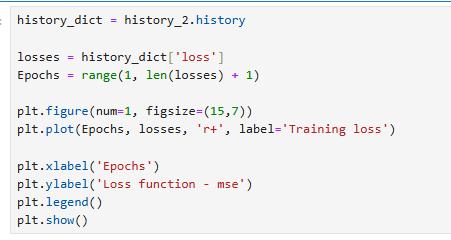

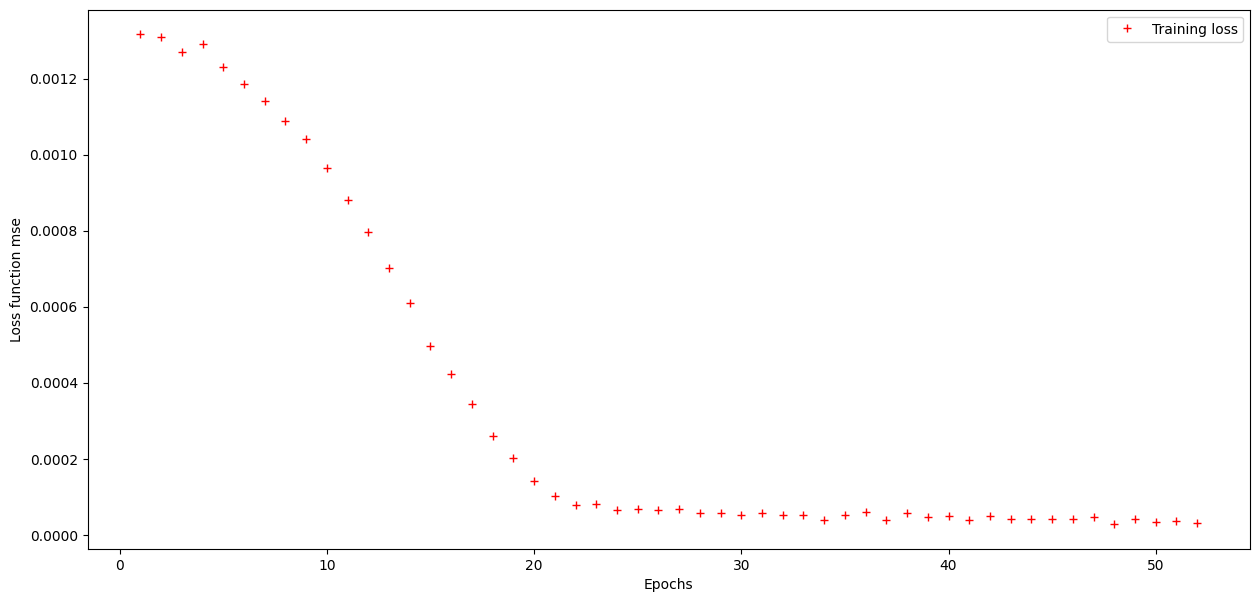

In [48]:
history_dict2 = history2.history
losses2 = history_dict2['loss']
Epochs2 = range(1, len(losses) + 1)
plt.figure(num=1, figsize=(15,7))
plt.plot(Epochs2, losses2, 'r+', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function mse')
plt.legend()
plt.show()

In [34]:
# Your code to Evaluate attention model on training set
# Your code to evaluate the attention model on the test set

train_mse_attn = model_attention.evaluate(trainX)
test_mse_attn = model_attention.evaluate(testX)


12/12 [==============================] - 0s 10ms/step - loss: 0.0000e+00


In [35]:
# Your code to print train error metric
# Your code to print test error metric

print("Train set MSE = ", train_mse_attn)
print("Test set MSE = ", test_mse_attn)

Train set MSE =  0.0
Test set MSE =  0.0


In [36]:
# Draw both loss functions' graphs together

________________________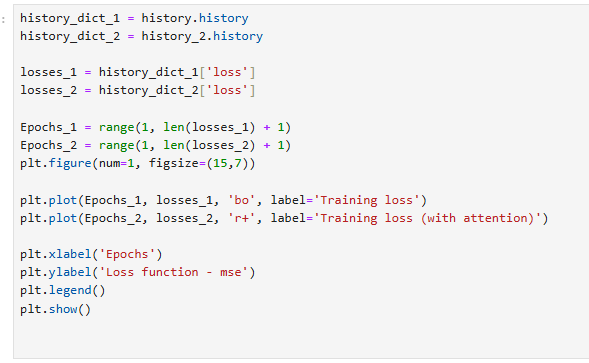

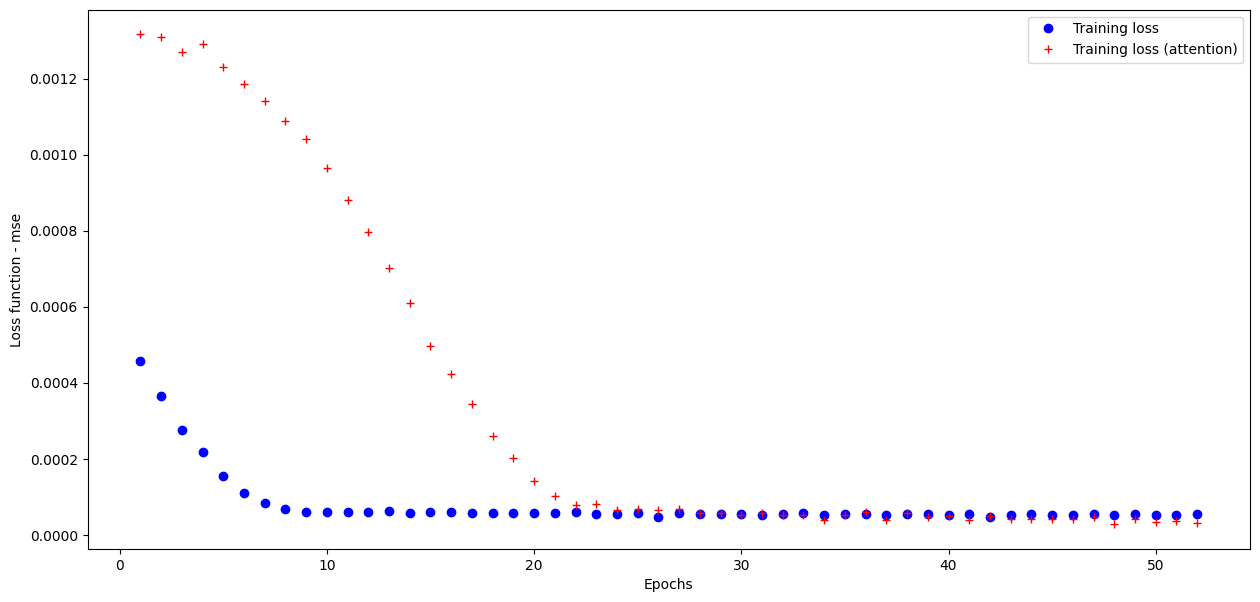

In [49]:
plt.figure(num=1, figsize=(15, 7))
plt.plot(Epochs, losses, 'bo', label='Training loss')
plt.plot(Epochs2, losses2, 'r+', label='Training loss (attention)')
plt.xlabel('Epochs')
plt.ylabel('Loss function - mse')
plt.legend()
plt.show()

### Plot the train and test MSE performance for the 'Simple RNN' and 'RNN with an attention layer'.


_________________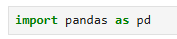

In [38]:
import pandas as pd

_______________________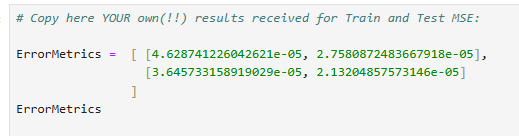

In [39]:
ErrorMetrics = [[train_mse, test_mse],[train_mse_attn, test_mse_attn]]
ErrorMetrics

[[4.242875729687512e-05, 2.570277138147503e-05], [0.0, 0.0]]

____________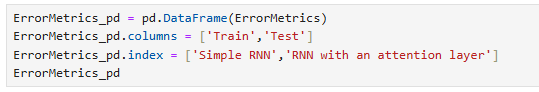

In [40]:
ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = ['Train','Test']
ErrorMetrics_pd.index = ['Simple RNN', 'RNN with an attention layer']
ErrorMetrics_pd

,Train,Test
Simple RNN,0.000042,0.000026
RNN with an attention layer,0.000000,0.000000


In [41]:
## MSE performance histogram

__________________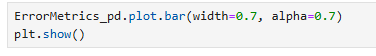

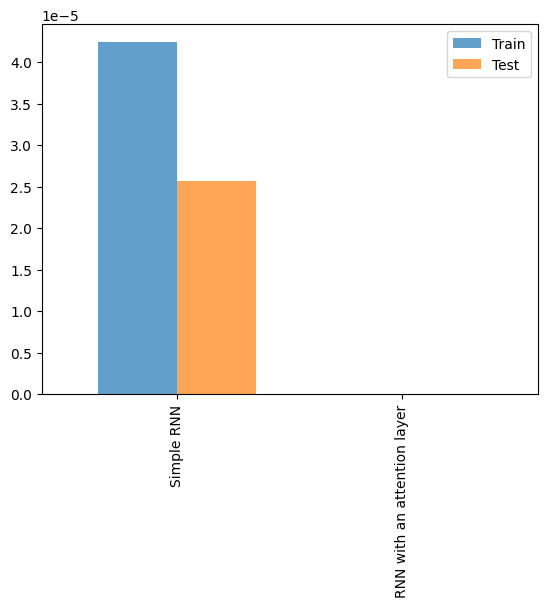

In [42]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)
plt.show()

# Lab Logbook Requirement:

<html> <h3 style="; color:blue;">

1) Modify the training parameter of the RNN with an attention layer model using the following formulas:

Modify the number of epochs:
Z + 50
, where your SID is: XXXXXXZ

Use EarlyStopping() and ModelCheckpoint() function to save the best modetl in the file 'best_attention_model.keras' 
Modify the patience parameter:
Z + 10
, where your SID is: XXXXXXZ

2) Modify time_steps = 20 and hidden_units = 4
3) Leave other parameters the same as in the practical session
4) Calculate and demonstrate the received loss for train and test datasets
5) Plot the Loss function (MSE) graph during the training process for the 3 models together
6) Please only add to your Lab Logbook print-screens of:
- calculation of your parameters
- your code of using EarlyStopping() and ModelCheckpoint() functions
- your code and training result using model.fit()
- received loss for train and test datasets
- Loss (MSE) graph for the 3 models together during the training process
- performance histogram for train and test loss (MSE) of the 3 models together


</h3> </html>


<html> <h3 style="color:red;">
NOTE: DON'T FORGET TO SAVE AND BACK UP YOUR COMPLETED JUPYTER NOTEBOOK AND LAB LOGBOOK ON GITHUB OR ONEDRIVE.
</h3> </html>

### Test the above model with different parameters, layer size, train and test ratio, and time steps.



__________________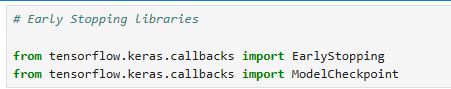

In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [44]:
es = EarlyStopping(monitor="val_loss", mode='min', patience=5, verbose=1)
mc = ModelCheckpoint("best_attention_model.keras", monitor="val_loss", mode='min', verbose=1, save_best_only=True)

________________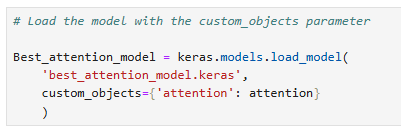

In [45]:
history3 = model_attention.fit(trainX,trainY, epochs=epochs, batch_size=1, verbose=1, callbacks=[es,mc])

Epoch 1/52
826/826 [==============================] - 22s 27ms/step - loss: 3.3831e-05
Epoch 2/52
826/826 [==============================] - 22s 27ms/step - loss: 3.9340e-05
Epoch 3/52
826/826 [==============================] - 21s 26ms/step - loss: 2.7007e-05
Epoch 4/52
826/826 [==============================] - 22s 26ms/step - loss: 1.9038e-05
Epoch 5/52
826/826 [==============================] - 22s 27ms/step - loss: 3.5375e-05
Epoch 6/52
826/826 [==============================] - 22s 27ms/step - loss: 2.7149e-05
Epoch 7/52
826/826 [==============================] - 22s 27ms/step - loss: 2.5912e-05
Epoch 8/52
826/826 [==============================] - 22s 26ms/step - loss: 2.2470e-05
Epoch 9/52
826/826 [==============================] - 22s 27ms/step - loss: 2.5363e-05
Epoch 10/52
826/826 [==============================] - 22s 27ms/step - loss: 2.2257e-05
Epoch 11/52
826/826 [==============================] - 22s 26ms/step - loss: 2.8028e-05
Epoch 12/52
826/826 [====================

In [46]:
# Your code of parameter modification

# time_steps = 

# hidden_units = 

# epochs = 

# patience =

In [47]:
# Continue your code according to the Lab Logbook Requirements ...


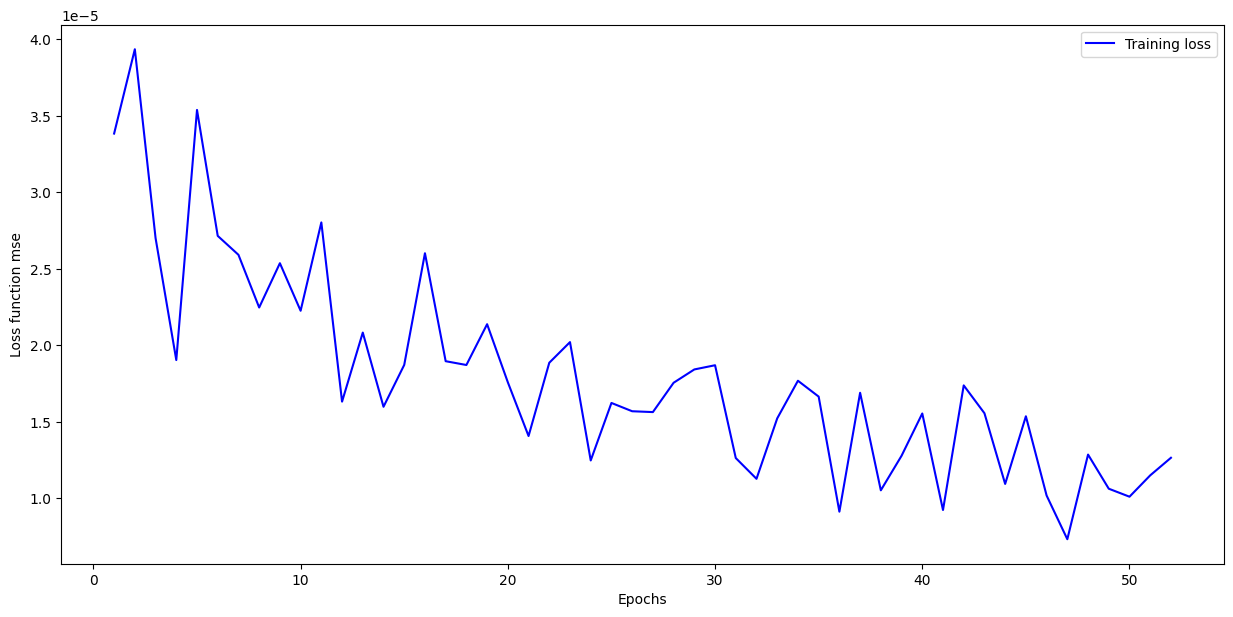

In [51]:
history_dict3 = history3.history
losses3 = history_dict3['loss']
Epochs3 = range(1, len(losses3) + 1)
plt.figure(num=1, figsize=(15,7))
plt.plot(Epochs3, losses3, 'b', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function mse')
plt.legend()
plt.show()

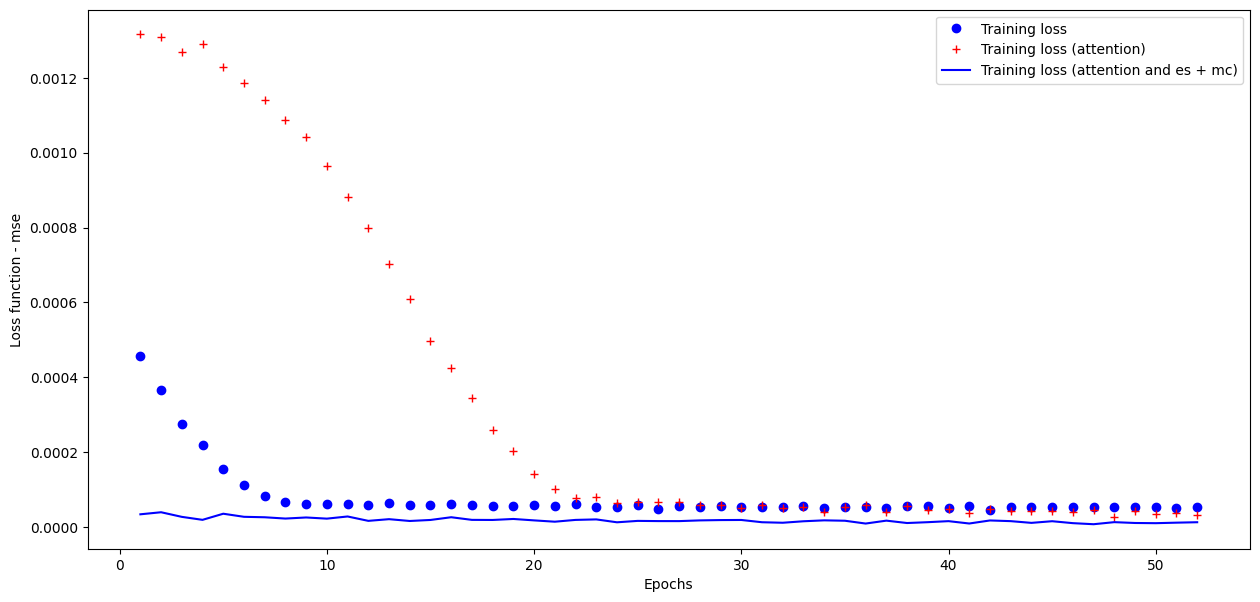

In [52]:
plt.figure(num=1, figsize=(15, 7))
plt.plot(Epochs, losses, 'bo', label='Training loss')
plt.plot(Epochs2, losses2, 'r+', label='Training loss (attention)')
plt.plot(Epochs3, losses3, 'b', label='Training loss (attention and es + mc)')
plt.xlabel('Epochs')
plt.ylabel('Loss function - mse')
plt.legend()
plt.show()

In [53]:
train_mse_attn2 = model_attention.evaluate(trainX)
test_mse_attn2 = model_attention.evaluate(testX)

12/12 [==============================] - 0s 9ms/step - loss: 0.0000e+00


In [58]:
print("Train set MSE = ", train_mse_attn2)
print("Test set MSE = ", test_mse_attn2)

Train set MSE =  0.0
Test set MSE =  0.0


In [54]:
ErrorMetrics = [[train_mse, test_mse],[train_mse_attn, test_mse_attn], [train_mse_attn2, test_mse_attn2]]
ErrorMetrics

[[4.242875729687512e-05, 2.570277138147503e-05], [0.0, 0.0], [0.0, 0.0]]

In [56]:
ErrorMetrics_pd = pd.DataFrame(ErrorMetrics)
ErrorMetrics_pd.columns = ['Train','Test']
ErrorMetrics_pd.index = ['Simple RNN', 'RNN with an attention layer', 'Simple RNN with attn layer and callbacks']
ErrorMetrics_pd

,Train,Test
Simple RNN,0.000042,0.000026
RNN with an attention layer,0.000000,0.000000
Simple RNN with attn layer and callbacks,0.000000,0.000000


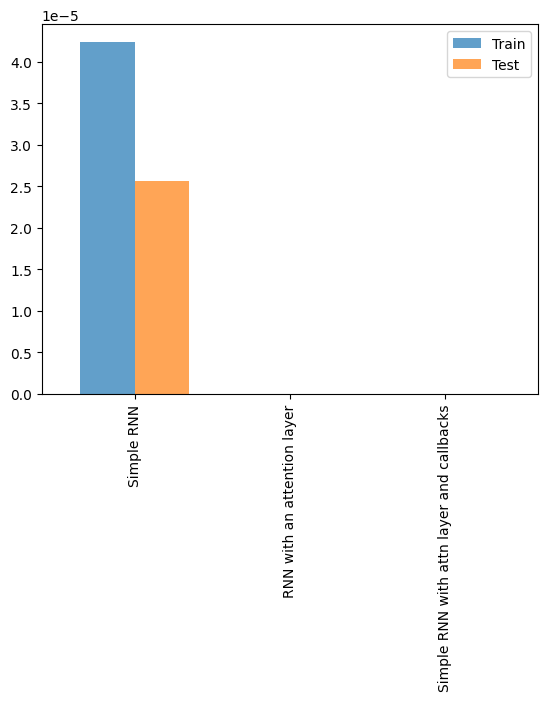

In [57]:
ErrorMetrics_pd.plot.bar(width=0.7, alpha=0.7)
plt.show()